# Multi-model Forest Fire Classifier

## Table of contents

1. Setup & environment

2. Problem statement & dataset overview

3. Code & repo layout

4. Training

5. Data loading and augmentation

6. Models

7. Evaluation

8. Conclusions & next steps

## 1. Setup & Environment

```
Python 3.12
numpy==2.3.2
torch==2.8.0
torchvision==0.23.0
fastapi==0.116.1
scikit-learn==1.7.1
matplotlib==3.10.5
pytorch-lightning==2.5.3
pandas==2.3.1
torchmetrics
tqdm
uvicorn
seaborn
python-multipart
```

In [1]:
# Imports
import os
# MUST be set before importing any PyTorch/CUDA modules
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import torch
# Configure PyTorch for full determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

import warnings
warnings.filterwarnings("ignore")

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns
import pandas as pd
from torchvision import datasets, transforms, models
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchmetrics import Accuracy, F1Score, Precision, Recall
from torchvision.transforms import v2
from tqdm import tqdm
import time
import re
from src.data.dataset import *
from src.training import *
from src.models import *
from src.config import configs

## 2. Problem statement & dataset overview
---

**The Objective:**<br>
By utilising a multimodal framework, combining the outputs of a vision transformer (ViT) and convolutional neural network (CNN) into a neural network, our proposed system aims to harness the complementary strengths of thermal data and RGB frames: thermal data reveal hidden heat anomalies, while RGB frames validate smoke and flame textures, together enabling robust detection even in low visibility conditions.

**Target Metrics:**<br>
To comprehensively evaluate the effectiveness of our proposed model, the accuracy metric is logged for training, validation, and testing phases. the model also tracks F1-Score, Precision, and Recall and generates key plots to visualise performance. By analysing these metrics, we were able to determine the strengths and weaknesses of our model and identify areas for potential improvement.

**Data Description:**<br>
The dataset used in this project is the FLAME 3 Dataset by Hopkins which was obtained via Kaggle. The dataset contains 622 images labelled as fire and 116 images labelled as no fire, with a memory size of 7.54 GB. All images in the dataset were collected from a single prescribed fire at Sycan Marsh, Oregon. Each image is part of a quartet of four images containing a raw RGB image, a raw thermal image, a corrected FOV RGB image and a Thermal TIFF. However, for this study, we only used the RGB and thermal images.


--- Train Split ---
Total samples: 873
Class 0: 243 (27.8%)
Class 1: 630 (72.2%)

--- Validation Split ---
Total samples: 63
Class 0: 18 (28.6%)
Class 1: 45 (71.4%)

--- Test Split ---
Total samples: 630
Class 0: 170 (27.0%)
Class 1: 460 (73.0%)


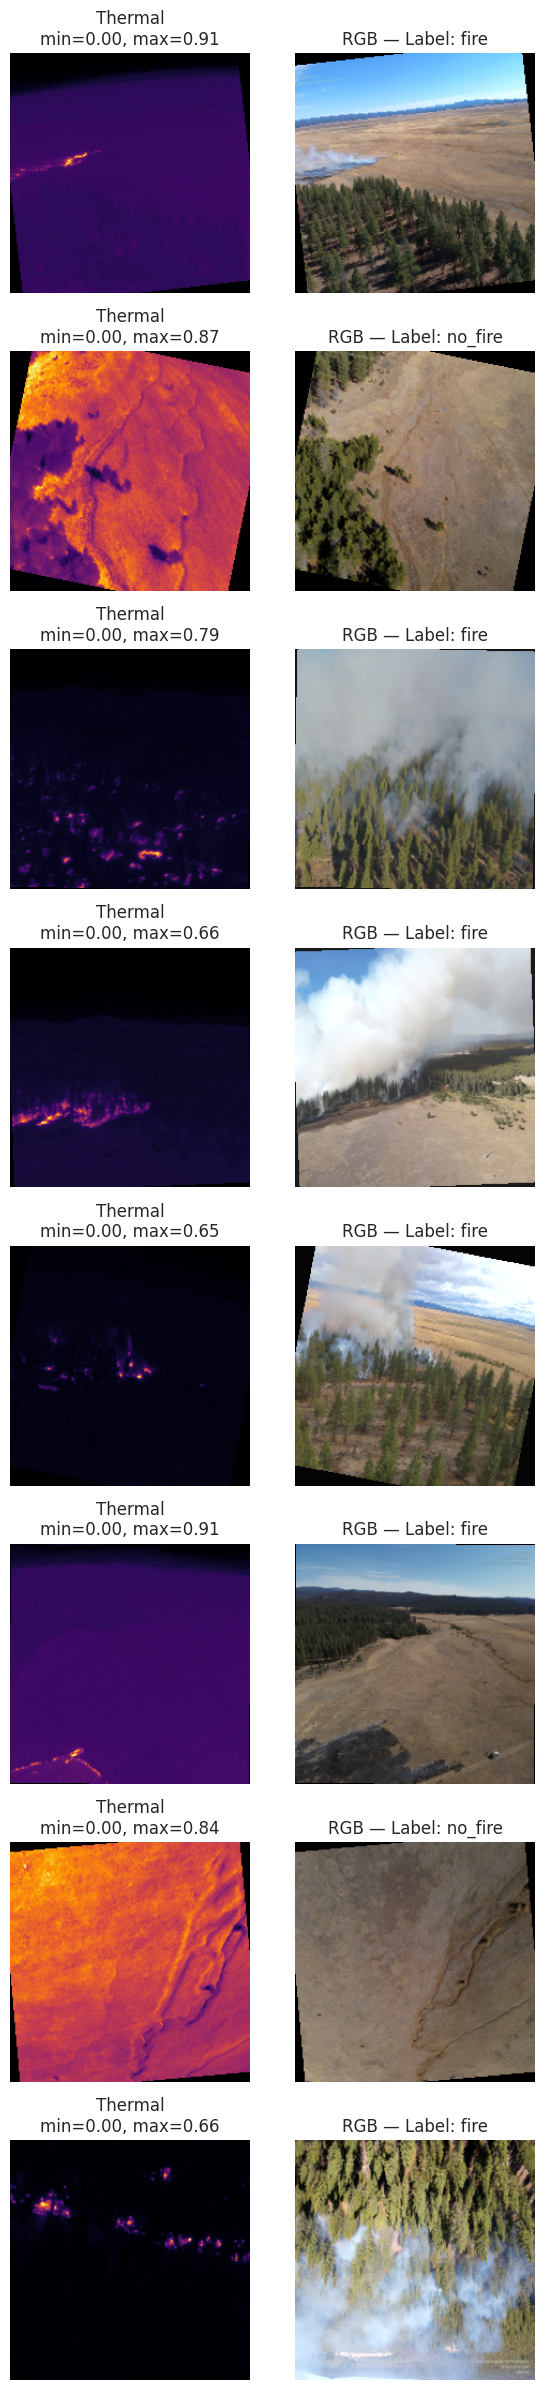

In [2]:
# Load datasets and dataloaders
dataset_config = {
        # Model
        "lr": 5e-4,
        "hidden_dim": 768,
        "dropout_rate": 0.2,
        "pos_weight": 1.0,
        "max_epochs": 20,
        "visuals": True, # If you want visualisations
        "weight_decay": 1e-4, # L2 regularization

        # Data
        "vit_fire_dir": "../dataset/raw/RGB/fire",
        "vit_non_fire_dir": "../dataset/raw/RGB/no_fire",
        "cnn_fire_dir": "../dataset/raw/thermal/fire",
        "cnn_non_fire_dir": "../dataset/raw/thermal/no_fire",
        "batch_size": 16,
        "img_size": (224, 224),
        "rotation": 15,
        "hflip_p": 0.5, # Horizontal flip probability
        "vflip_p": 0.5, # Vertical flip probability
        "multiplier": 3
}

dataloaders = prepareCombinedDataset(config=dataset_config)
train_loader, _, _ = dataloaders["fusion"]

# Take a batch from the train loader
vit_batch, cnn_batch, labels = next(iter(train_loader))

# Pick 6–8 samples from the batch
num_samples = min(8, vit_batch.size(0))

fig, axes = plt.subplots(num_samples, 2, figsize=(6, num_samples*3))

for i in range(num_samples):
    rgb = vit_batch[i].numpy().transpose(1, 2, 0)  # [H,W,C]
    thermal = cnn_batch[i].squeeze().numpy()       # [H,W]
    label = int(labels[i].item())

    # Undo normalization for display (RGB was normalized with ImageNet stats)
    rgb_disp = rgb * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    rgb_disp = np.clip(rgb_disp, 0, 1)

    # Undo normalization for thermal (normalized with mean=0.5, std=0.5)
    thermal_disp = (thermal * 0.5 + 0.5)  # back to [0,1] range
    thermal_min, thermal_max = thermal_disp.min(), thermal_disp.max()

    # Plot thermal
    axes[i, 0].imshow(thermal_disp, cmap="inferno")
    axes[i, 0].set_title(f"Thermal\nmin={thermal_min:.2f}, max={thermal_max:.2f}")
    axes[i, 0].axis("off")

    # Plot RGB
    axes[i, 1].imshow(rgb_disp)
    axes[i, 1].set_title(f"RGB — Label: {'fire' if label==1 else 'no_fire'}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

## 3. Code & Repo Layout
---
**Project Strucutre Overview:**<br>
Below is a high-level map of the repo with each file's role:
```
src/
├── __init__.py
├── app.py                     # (optional) entrypoint / app logic
├── config.py                  # configuration handling (paths, hyperparameters)
│
├── data/
│ └── dataset.py               # Dataset classes & transforms (RGB, Thermal, Fusion)
│
├── models/
│ ├── __init__.py
│ ├── feature_vector_NN.py     # MLP classifier for feature vectors
│ ├── fusion.py                # Fusion head combining RGB + Thermal features
│ ├── RGB_vit.py               # Vision Transformer wrapper for RGB input
│ └── thermal_cnn.py           # MobileNetV2 adaptation for thermal input
│
├── saved/
│ ├── features/                # Stored feature vectors (embeddings)
│ └── figures/                 # Plots and visualizations
│
├── static/
│ └── index.html               # Web/static frontend (if serving an app)
│
└── training/
   ├── __init__.py
   ├── main.py                 # Training orchestration script
   ├── train_cnn.py            # Train thermal CNN model
   ├── train_fusion.py         # Train fusion model (RGB + Thermal)
   └── train_vit.py            # Train RGB Vision Transformer model
```

**Key points:**
- ```src/data/```: dataset building, preprocessing, and augmentations.
- ```src/models/```: model definitions for thermal CNN, RGB ViT, fusion and MLP classifier.
- ```src/training/```: training scripts for each modality or combined fusion.
- ```src/saved/```: outputs like feature vectors and plots.
- ```src/static/```: Optional web front-end resources.

## 4. Training
Full Training and feature extractor saving.

In [5]:
# Define Configs
vit_config = {
    "num_epochs": 40,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "freeze_backbone": True,
    "pretrained": True,
    "dropout_rate": 0.5,
    "pos_weight": None,
    "save_FE_path": "features/ViT_fire_feature_extractor.pth", # Save feature extractor path
}

cnn_config = {
    "num_epochs":15,
    "lr": 1e-4,
    "max_grad_norm": 0.1,
    "dropout_rate": 0.3,
    "save_FE_path": "features/CNN_fire_feature_extractor.pth",
}

fusion_config = {
    "lr": 5e-4,
    "hidden_dim": 768,
    "dropout_rate": 0.2,
    "pos_weight": 1.0,
    "max_epochs": 20,
    "visuals": False, # If you want visualisations
    "weight_decay": 1e-4, # L2 regularization
}

In [6]:
# ---- CNN Branch Training ----
print("CNN Training Starting...\n")
# Clear GPU memory cache
torch.cuda.empty_cache()

# Access thermal dataloaders
thermal_train, thermal_val, thermal_test = dataloaders["thermal"]

# Train model
train_cnn(cnn_config, thermal_train, thermal_val, thermal_test)

CNN Training Starting...

Class counts: [243, 630], pos_weight=0.386


Epoch 15/15 [Train]: 100%|██████████| 55/55 [00:42<00:00,  1.29it/s, acc=1, loss=2.96e-9] 



=== Final Model Statistics ===
Training Accuracy   : 1.0000
Validation Accuracy : 1.0000
Test Accuracy       : 1.0000


CNN(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1),

In [7]:
# ---- ViT Branch Training ----
print("ViT Training Starting...\n")
# Clear GPU memory cache
torch.cuda.empty_cache()

# Access thermal dataloaders
rgb_train, rgb_val, rgb_test= dataloaders["rgb"]

# train Model
train_vit(vit_config, rgb_train, rgb_val, rgb_test)

ViT Training Starting...

ViT pos_weight:  0.38571428571428573


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | vit        | VisionTransformer | 85.8 M | train
1 | classifier | Sequential        | 197 K  | train
2 | train_acc  | BinaryAccuracy    | 0      | train
3 | val_acc    | BinaryAccuracy    | 0      | train
4 | test_acc   | BinaryAccuracy    | 0      | train
---------------------------------------------------------
197 K     Trainable params
85.8 M    Non-trainable params
86.0 M    Total params
343.985   Total estimated model params size (MB)
160       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 55/55 [00:48<00:00,  1.14it/s, v_num=6, train_loss_step=0.138] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 55/55 [00:48<00:00,  1.14it/s, v_num=6, train_loss_step=0.158, val_loss=0.0467, val_acc=0.984, train_loss_epoch=0.163, train_acc=0.856] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 55/55 [00:48<00:00,  1.14it/s, v_num=6, train_loss_step=0.397, val_loss=0.0323, val_acc=1.000, train_loss_epoch=0.0792, train_acc=0.940] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 55/55 [00:48<00:00,  1.14it/s, v_num=6, train_loss_step=0.0506, val_loss=0.0342, val_acc=1.000, train_loss_epoch=0.0646, train_acc=0.960]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 55/55 [00:48<00:00,  1.14it/s, v_num=6, train_loss_step=0.0891, val_loss=0.0264, val_acc=1.000, train_loss_epoch=0.0547, train_acc=0.969] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:25<00:00,  1.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9952380657196045
        test_loss           0.03334465250372887
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Lightning Test Accuracy: 1.00


(ViT(
   (vit): VisionTransformer(
     (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
     (encoder): Encoder(
       (dropout): Dropout(p=0.0, inplace=False)
       (layers): Sequential(
         (encoder_layer_0): EncoderBlock(
           (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
           (self_attention): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
           )
           (dropout): Dropout(p=0.0, inplace=False)
           (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
           (mlp): MLPBlock(
             (0): Linear(in_features=768, out_features=3072, bias=True)
             (1): GELU(approximate='none')
             (2): Dropout(p=0.0, inplace=False)
             (3): Linear(in_features=3072, out_features=768, bias=True)
             (4): Dropout(p=0.0, inplace=False)
           )
         )
         (encoder_layer_1): EncoderBlock(
         

In [8]:
# ---- Fusion Training ----
print("Fusion Training Starting...\n")
# Load pretrained feature extractors
print("Loading pretrained feature extractors...")
vit_extractor = ViT.load_from_checkpoint(
    "features/ViT_fire_feature_extractor.pth"
)
cnn_extractor = CNN(cnn_config)
cnn_extractor.load_state_dict(
    torch.load("features/CNN_fire_feature_extractor.pth"),
    strict=False
)
cnn_extractor.classifier = nn.Identity()

vit_extractor.eval()
cnn_extractor.eval()
print("Feature extractors ready.")

# Access fusion dataloaders
fusion_train, fusion_val, fusion_test = dataloaders["fusion"]

# Train fusion model
print("\nTraining fusion model...")
fusion_model, results = train_fusion(
    vit_extractor=vit_extractor,
    cnn_extractor=cnn_extractor,
    config=fusion_config,
    train_dataloader=fusion_train,
    val_dataloader=fusion_val,
    test_dataloader=fusion_test,
    notebook=True
)

# Save trained weights
fusion_model.eval()
torch.save(fusion_model.state_dict(), "features/fusion_model_weights.pth")
print("Fusion model weights saved.")

# Initialize predictor for deployment
predictor = FusionModelPredictor(fusion_model, vit_extractor, cnn_extractor)
print("Fire predictor initialized.")

Fusion Training Starting...

Loading pretrained feature extractors...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | vit_extractor | ViT               | 86.0 M | eval 
1 | cnn_extractor | CNN               | 4.2 M  | eval 
2 | classifier    | Sequential        | 986 K  | train
3 | criterion     | BCEWithLogitsLoss | 0      | train
4 | train_acc     | BinaryAccuracy    | 0      | train
5 | val_acc       | BinaryAccuracy    | 0      | train
6 | test_acc      | BinaryAccuracy    | 0      | train
------------------------------------------------------------
986 K     Trainable params
90.2 M    Non-trainable params
91.1 M    Total params
364.570   Total estimated model params size (MB)
10        Modules in train mode
383       Modules in eval mode


Feature extractors ready.

Training fusion model...
Initializing fusion model...

Starting training...
Epoch 0: 100%|██████████| 55/55 [00:37<00:00,  1.46it/s, v_num=7, train_loss_step=0.00865] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 55/55 [00:42<00:00,  1.29it/s, v_num=7, train_loss_step=0.00865, val_loss=0.00191, val_acc=1.000, train_loss_epoch=0.0547, train_acc=0.978]

Metric val_acc improved. New best score: 1.000


Epoch 1: 100%|██████████| 55/55 [00:37<00:00,  1.46it/s, v_num=7, train_loss_step=0.0419, val_loss=0.00191, val_acc=1.000, train_loss_epoch=0.0547, train_acc=0.978]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 55/55 [00:37<00:00,  1.46it/s, v_num=7, train_loss_step=1.87e-5, val_loss=0.00147, val_acc=1.000, train_loss_epoch=0.00676, train_acc=1.000] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 55/55 [00:37<00:00,  1.46it/s, v_num=7, train_loss_step=0.000593, val_loss=0.000633, val_acc=1.000, train_loss_epoch=0.0211, train_acc=0.991]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 55/55 [00:37<00:00,  1.46it/s, v_num=7, train_loss_step=0.00564, val_loss=0.000246, val_acc=1.000, train_loss_epoch=0.00419, train_acc=1.000] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 55/55 [00:37<00:00,  1.46it/s, v_num=7, train_loss_step=1.28e-5, val_loss=0.000102, val_acc=1.000, train_loss_epoch=0.

Monitored metric val_acc did not improve in the last 5 records. Best score: 1.000. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 55/55 [00:46<00:00,  1.19it/s, v_num=7, train_loss_step=1.28e-5, val_loss=8.9e-5, val_acc=1.000, train_loss_epoch=0.00308, train_acc=0.999]

Loading best checkpoint: /home/carbs/Desktop/Projects/ViT-Based_ForestFire/REPO/forest_fire_detection/notebooks/lightning_logs/version_7/checkpoints/best-fusion-model.ckpt

--- Train Classification Report ---
              precision    recall  f1-score   support

     No Fire       1.00      1.00      1.00       243
        Fire       1.00      1.00      1.00       630

    accuracy                           1.00       873
   macro avg       1.00      1.00      1.00       873
weighted avg       1.00      1.00      1.00       873


--- Validation Classification Report ---
              precision    recall  f1-score   support

     No Fire       1.00      1.00      1.00        18
        Fire       1.00      1.00      1.00        45

    accuracy                           1.00        63
   macro avg       1.00      1.00    

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Test Classification Report ---
              precision    recall  f1-score   support

     No Fire       1.00      1.00      1.00       170
        Fire       1.00      1.00      1.00       460

    accuracy                           1.00       630
   macro avg       1.00      1.00      1.00       630
weighted avg       1.00      1.00      1.00       630


Evaluating with Lightning test loop...
Testing DataLoader 0: 100%|██████████| 40/40 [00:23<00:00,  1.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss          0.002236480824649334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Fusion model weights saved.
Fire

## 5. Data loading and augmentation
---
**Goal:** keep RGB and thermal pipelines comparable in spatial geometry while respecting modality differences (colour vs intensity), and avoid heavy perturbations that would harm alignment and orientation-dependent cues.

#### **RGB (ViT input)**
- **Resize:** ```Resize((224, 224))``` ensures fixed spatial size for the backbone and aligned pairs with thermal images.
- **Random flips:** ```RandomHorizontalFlip()``` and ```RandomVerticalFlip()``` increases viewpoint robustness.
- **Random Rotation:** ```RandomRotation(15)``` adds mild viewpoint invariance without breaking pair alignment or producing unrealistic geometry. Rotation is capped because orientation cues can matter for detection.
- **Colour Jitter (RGB Only):** ```ColorJitter(0.2, 0.2, 0.2)``` Simulates camera/exposure variability. Not applied to thermal to avoid distorting the physical intensity signal.
- **Tensor + Normalization:** ```ToTensor()``` then ```Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])``` Standard ImageNet stats keep initialisation-friendly ranges for the ViT backbone.

**Eval:** only Resize, ToTensor, and Normalize no stochastic augmentations.

#### **Thermal (CNN input)**
- **Resize:** ```Resize((224,224))```
- **Random flips:** ```RandomHorizontalFlip()``` and ```RandomVerticalFlip()```
- **Random Rotation:** ```RandomRotation(15)```
- **Modality conversions & Scaling:**  ```ToImage()``` into ```ToDtype(torch.float32, scale=True)``` into ```Grayscale(num_output_channels=1)``` Forces consistent tensor dtype/range and a single-channel representation.
- **Normalization:** ```Normalize(mean=[0.5], std=[0.5])``` Map intensities to roughly ```[-1, 1]``` after 0-1 scaling. keeps a simple symmetric range tailored to single-channel inputs.

**Eval:** Resize into ToImage into ToDtype into Grayscale into Normalize.

In [9]:
# Grab one example from the train dataset (not loader) so transforms are re-applied each time
train_dataset = dataloaders["fusion"][0].dataset.dataset  # unwrap Subset -> FusionDataset
sample_idx = 0  # change index if you want a different image
vit_path = train_dataset.vit_paths[sample_idx]
cnn_path = train_dataset.cnn_paths[sample_idx]
label = train_dataset.labels[sample_idx]

# How many augmentations to visualize
n_aug = 6
fig, axes = plt.subplots(2, n_aug, figsize=(3*n_aug, 6))

for i in range(n_aug):
    with Image.open(vit_path) as rgb_img:
        rgb_img = rgb_img.convert("RGB")
        vit_t = train_dataset.vit_train_transform(rgb_img)
    with Image.open(cnn_path) as thm_img:
        cnn_t = train_dataset.cnn_train_transform(thm_img)

    # De-normalize for display
    rgb_disp = vit_t.clone().permute(1, 2, 0).numpy()
    rgb_disp = rgb_disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    rgb_disp = np.clip(rgb_disp, 0, 1)

    thm_disp = cnn_t.clone().squeeze().numpy()
    thm_disp = (thm_disp * 0.5 + 0.5).clip(0, 1)

    axes[0, i].imshow(rgb_disp)
    axes[0, i].set_title(f"RGB aug #{i+1}")
    axes[0, i].axis("off")

    axes[1, i].imshow(thm_disp, cmap="inferno")
    axes[1, i].set_title(f"Thermal aug #{i+1}")
    axes[1, i].axis("off")

plt.suptitle(f"Augmentations for label: {'fire' if label==1 else 'no_fire'}", fontsize=14)
plt.tight_layout()
plt.show()

AttributeError: 'AugmentedDataset' object has no attribute 'dataset'

## 6. Models definitions: architecture summaries, rationale, and instantiation code
---

#### **CNN** (```src/models/thermal_cnn.py```)
**Architecture summary**
- Base: ```torchvision.models.movilenet_v2``` (backbone features retained).
- First convolution (```features[0][0]```) changed from ```in_channels=3``` to ```in_channels=1``` to accept single-channel thermal images.
- The New first-conv weights are initialised by taking the mean across the original RGB channels: ```new_weight = original_first_conv.weight_mean(dim=1, keepdim=True)```
- After the backbone features we apply ```AdaptiveAvgPool2d((1,1))``` and ```Flatten()``` to produce a pooled feature vector.
- A small feature refinement head maps the pooled ```feature_dim``` down to **512** using ```Linear(feature_dim, 512)```, ```ReLU```, and ```Dropout```.

**Rationale**
- MobileNetV2 is lightweight and performs well on small/embedded setups. Using it for thermal imagery gives a good tradeoff between compute and representational power.
- Replacing the first conv to accept single-channel thermal input avoids repeating channels or learning from scratch. initialising it as the mean of pretrained RGB weights transfers low-level filters (edges/textures) that are still useful for thermal data, ensuring we still get the most out of the transfer learning.
- Producing a compact 512-dim feature vector keeps the fusion vector size reasonable while preserving discriminative power.

**Pretrained weights**
- The backbone is instantiated with ImageNet pretrained weights (```IMAGENET1K_V1```).

<br>

#### **ViT** (```src/models/RGB_vit.py```)
**Architecture summary**
- Base: ```torchvision.models.vit_b_16``` Vision Transformer with patch size **16x16** and embedding dimension **768**.
- The ViT's classification head is replaced with ```nn.Identity()``` such that teh forward pass returns raw 768-dim patch embeddings.
- Optionally a small ```classifier``` head (256 to 1) exists for standalone ViT training/evaluation.

**Rationale**
- ViT-B/16 with 768-d embeddings provides a strong, high-capacity feature extractor for RGB images and pairs well with CNN thermal features.
- Returning the raw 768-d embedding simplifies fusion: we treat the ViT as a feature extractor rather than a standalone classifier.

**Pretrained weights**
- This model uses ```ViT_B_16_Weights.IMAGENET1K_V1```, which is the same as the CNN.

<br>

#### Fusion head (```src/models/fusion.py``` + ```feature_vector_NN.py```)
**Architecture summary**
- Feature extractors produce vectors of size **CNN = 512** and **ViT = 768**.
- The fusion concatenates the two feature vectors: ```combined = torch.cat((vit_features, cnn_features), dim=1)``` into a 1280-dimensional vector.
- A compact MLP processes the concatenated vector: ```Linear(1280, hidden_dim)``` into ```ReLU``` into ```BatchNorm1d``` into ```Dropout``` into ```Linear(hidden_dim, 1)```.
- The Model returns raw logits. At inference, apply ```sigmoid(logits)``` to get probabilities.

**Rationale**
- Concatenation is a simple, effective late fusion method that preserves modality-specific features while enabling the classifier to learn cross-model interactions.
- Using frozen extractors minimizes overfitting and drastically reduces the number of trainable parameters to those in the fusion head, making training stable with limited multimodal data.

#### Code Cell: Instantiate each model and show parameter counts

In [10]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable


def instantiate_and_print(config=None, device='cpu'):
    config = config or {}

    vit_cfg = dict(pretrained=True, freeze_backbone=True, dropout_rate=0.5)
    vit_cfg.update(config.get('vit', {}))
    vit = ViT(vit_cfg).to(device)

    cnn_cfg = {'dropout_rate': config.get('dropout_rate', 0.4)}
    cnn = CNN(cnn_cfg).to(device)

    fusion_cfg = {"dropout_rate": config.get('dropout_rate', 0.4), "hidden_dim": config.get('hidden_dim', 512)}
    fusion = FusionNN(vit_extractor=vit, cnn_extractor=cnn, config=fusion_cfg).to(device)

    models = {'RGB_ViT': vit, 'Thermal_CNN': cnn, 'FusionNN': fusion}

    for name, m in models.items():
        total, trainable = count_parameters(m)
        print(f"{name}: total = {total:,}, trainable = {trainable:,}")

    return vit, cnn, fusion

vit, cnn, fusion = instantiate_and_print()

KeyError: 'pos_weight'

#### Parameter counts & approx FLOPS

| Model             | Estimated Total Parameters                | Estimated trainable params | Approx FLOPS (single forward, image 224x224) |
|-------------------|-------------------------------------------|----------------------------|----------------------------------------------|
| CNN               | ~3.4M (backbone) + 0.7M (refiner) = ~4.1M | ~0.7M (feature refiner)    | ~300 MFLOPS                                  |
| ViT               | ~86M                                      | 0 (if frozen)              | ~17-20 GFLOPS                                |
| Fusion head (MLP) | ~0.6M (depends on ```hidden_dim```)             | ~0.6M                      | negligible                                   |
| **Full Pipeline** | **~90-95M**                               | **~0.6-0.7M**              | **~18-20 GFLOPS**                            |

## 7. Evaluation

In [11]:
# --- Load feature extractors (same as in train_fusion.py) ---
vit_extractor = ViT.load_from_checkpoint("features/ViT_fire_feature_extractor.pth")
cnn_extractor = CNN(configs("CNN"))
cnn_extractor.load_state_dict(
    torch.load("features/CNN_fire_feature_extractor.pth"),
    strict=False,
)
cnn_extractor.classifier = nn.Identity()
vit_extractor.eval()
cnn_extractor.eval()

# --- Rebuild fusion model ---

model = FusionNN(vit_extractor, cnn_extractor, config=fusion_config)
state_dict = torch.load("features/fusion_model_weights.pth", map_location="cpu")
model.load_state_dict(state_dict)
print("Fusion model weights loaded.")

# --- Dataloaders ---
train_loader, val_loader, test_loader = dataloaders["fusion"]

# --- Move to device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# --- Evaluate ---
y_train, p_train = evaluate_classification_report_with_probs(model, train_loader, device, "Train")
evaluate_classification_report_with_probs(model, val_loader, device, "Validation")
y_test, p_test = evaluate_classification_report_with_probs(model, test_loader, device, "Test")

# --- Lightning-style test loop (optional, for metrics + visuals if enabled) ---
trainer = pl.Trainer(accelerator="auto", devices="auto")
trainer.test(model, dataloaders=test_loader)

# --- Optional precision-recall comparison ---
if model.visuals:
    model.plot_precision_recall_comparison(y_train, p_train, y_test, p_test)


Fusion model weights loaded.

--- Train Classification Report ---
              precision    recall  f1-score   support

     No Fire       1.00      1.00      1.00       243
        Fire       1.00      1.00      1.00       630

    accuracy                           1.00       873
   macro avg       1.00      1.00      1.00       873
weighted avg       1.00      1.00      1.00       873


--- Validation Classification Report ---
              precision    recall  f1-score   support

     No Fire       1.00      1.00      1.00        18
        Fire       1.00      1.00      1.00        45

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Test Classification Report ---
              precision    recall  f1-score   support

     No Fire       1.00      1.00      1.00       170
        Fire       1.00      1.00      1.00       460

    accuracy                           1.00       630
   macro avg       1.00      1.00      1.00       630
weighted avg       1.00      1.00      1.00       630

Testing DataLoader 0: 100%|██████████| 40/40 [00:28<00:00,  1.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss          0.0021391466725617647
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## 8. Conclusion
---
In this research, we investigated whether a feature-level fusion of RGB and thermal imagery using a hybrid ViT + CNN architecture could be effective for early forest fire detection, relative to unimodal approaches. Motivated by the strengths of both modalities, thermal revealing heat patterns and RGB finding contextual and textural clues, we developed FusionNN. This hybrid model consisted of a pretrained ViT backbone for RGB, a lightweight adapted MobileNetV2 CNN for thermal inputs, and a compact fusion neural network classifier which combined their embeddings.

On the FLAME3 benchmark, FusionNN demonstrated strong discriminative ability. The fusion model produced an accuracy of 98.6% and an F1 score approaching 0.99 on the test set. Additionally, it converged rapidly during training and maintained low validation loss throughout. These results indicate the proposed fusion strategy preserves modality-specific information while creating a joint representation that separates fire and non-fire examples effectively.

Beyond raw metrics, the study offers practical implications. The fusion pipeline uses a computationally lightweight thermal branch and a frozen ViT for RGB, which could suggest a pathway towards edge-capable deployments (for example on drones). Moreover, the model’s rapid convergence suggests training efficiency, which is valuable when models must be retrained or adapted in new geographic regions.

However, there are several important caveats to these results. The FLAME3 dataset, while it does provide both thermal and RGB, it is derived from a single prescribed fire and contains relatively few unique scenes; augmentation was used to address this issue for both training and testing datasets. This could suggest that the evaluation metrics are optimistic relative to real-world deployment. Additional concerns include the class imbalance, with limited number of non-fire examples in the dataset.

To effectively evaluate this approach, future work must prioritise external validation and robustness. Specifically, we recommend larger, multi-site datasets that capture seasonal, geographic, and sensor variability. In addition to, performing controlled degradation experiments (smoke, haze, low light) to test resilience. Moreover, we should evaluate the model parameter count, inference time, and memory usage during training. Analysing these metrics, we can identify the strengths and weaknesses of our model and identify areas for potential improvement.

In summary, the proposed FusionNN offers a compelling avenue for earlier and more reliable wildfire detection than unimodal. The current results provide a proof-of-concept, but translating this approach into a reliable deployable system will require broader datasets, robustness testing, and hardware-aware optimisations.  